In [39]:
import numpy as np
import tensorflow as keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow import keras

# Diretórios de dados
base_dir = 'Imagens/'

train_dir = os.path.join(base_dir, 'train/train5')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

**Data Augmentation**

- Esta técnica é bastante forte contra overfitting pois é um aumento de dados artificial com rotações, zoom, contraste, etc.., o que expõe o modelo a uma variedade maior de exemplos durante o treino, o que força o modelo a aprender características invariantes das classes em vez de memorizar exemplos específicos.

- No nosso caso utilizamos dois tipos de data augmentation, o fornecido na diciplina e uma forma de data augmentation utilizando o ImageDataGenerator que tem um mais de parâmetros de pré processamento e de data augmentation

In [40]:
# Configuração do ImageDataGenerator
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
    ]
)

datagen = ImageDataGenerator(rescale=1./255)

IMG_SIZE = 32
BATCH_SIZE = 32
num_classes = 10

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical' 
)

validation_dataset = datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)

test_dataset = datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)


Found 40000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


**Arquitetura**
- A data agumentation é uma função ou camada que aplica aumentação de dados, essencial para melhorar a generalização e robustez do modelo ao introduzir variações nos dados de treino.

**Regularização L2**
- Aplicamos nas camadas convolucionais e densas para penalizar os pesos grandes na função de *loss* durante o treino, o que ajuda a evitar *overfitting* ao reduzir a complexidade do modelo

**Otimizador**
- O modelo é compilado com o otimizador Adam (optimizer=Adam(learning_rate=0.0001)), que é amplamente utilizado devido à sua eficiência em ajustar as taxas de aprendizagem de forma adaptativa para cada parâmetro da rede neuronal e foi também o otimizador que mais utilizamos nada aulas

**Função Loss**
- A função de *loss* escolhida foi a categorical_crossentropy, adequada para problemas de classificação multiclasse

**Métrica da avaliação**

- A métrica de avaliação durante o treino foi a acurácia (metrics=['accuracy']), que mede a proporção de *predicts* corretas em relação ao total de previsões

**Layers Convolucionis**
- Cada uma das camadas convolucionais (Conv2D) é seguida pela ativação ReLU (activation='relu'), utilizando padding do tipo 'same' para manter o tamanho da saída igual ao da entrada (padding='same').  - Além disso, aplicámos regularização do kernel através do kernel_regularizer=l2(0.0001), que aplica regularização L2 para ajudar a evitar overfitting.
- Após cada camada convolucional, aplicámos normalização de batch (BatchNormalization) para acelerar o treino e melhorar a estabilidade do modelo.
- Posteriormente, é utilizado um pooling máximo (MaxPooling2D) com uma janela de (2, 2) para reduzir a dimensionalidade dos dados e extrair características mais importantes da imagem.

**Camada Flatten**
- Transforma a saída das camadas convolucionais em um vetor unidimensional para ligar a parte convolucional à *fully connected* da rede

**Camadas Fully Connected**

- A primeira camada densa (Dense) com 512 unidades, ativação ReLU, e regularização do kernel através do kernel_regularizer=l2(0.001).
Normalização de batch (BatchNormalization) e dropout de 30% (Dropout(0.3)) para a regularização e prevenção do *overfitting*.


In [41]:
from tensorflow.keras.layers import GlobalAveragePooling2D
# Definindo o input
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Aplicando Data Augmentation
x = data_augmentation(inputs)

# Primeira camada convolucional
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001))(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.3)(x)

# Segunda camada convolucional
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.3)(x)

# Terceira camada convolucional
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.3)(x)

# Quarta camada convolucional
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.4)(x)

# Camada de Flatten
x = layers.Flatten()(x)

# Camada totalmente conectada
x = layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
# Camada de saída
outputs = layers.Dense(10, activation='softmax')(x)  # Supondo 10 classes

# Definindo o modelo
model = Model(inputs=inputs, outputs=outputs)

# Compilando o modelo
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_20 (Ba  (None, 32, 32, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 16, 16, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 128)       7385

**Callbacks**

- É uma mais valia para os treinos foi o early_stopping que, se o val_loss nao mudar durante 10 epocas ele parar de treinar e fica com os melhores pesos que teve
- ReduceLr vai reduzindo o lr se mantiver o val_loss com 0.1 durante 5 vezes

In [43]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)#Se o val_loss nao mudar durante 10 epocas ele para de treianr e fica com os melhores pesos que teve
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)#Vai reduzindo o lr se mantiver o val_loss com 0.1 durante 5 vezes

In [44]:
# Treinar o modelo
history = model.fit(train_generator, epochs=100 ,validation_data=validation_dataset, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
1250/1250 [==============================] - 91s 72ms/step - loss: 3.2582 - accuracy: 0.2993 - val_loss: 2.6926 - val_accuracy: 0.4049 - lr: 1.0000e-04
Epoch 2/100
1250/1250 [==============================] - 91s 72ms/step - loss: 2.6692 - accuracy: 0.4018 - val_loss: 2.5478 - val_accuracy: 0.4512 - lr: 1.0000e-04
Epoch 3/100
1250/1250 [==============================] - 87s 70ms/step - loss: 2.3859 - accuracy: 0.4638 - val_loss: 2.4864 - val_accuracy: 0.4559 - lr: 1.0000e-04
Epoch 4/100
1250/1250 [==============================] - 86s 69ms/step - loss: 2.1586 - accuracy: 0.5124 - val_loss: 2.1695 - val_accuracy: 0.5325 - lr: 1.0000e-04
Epoch 5/100
1250/1250 [==============================] - 86s 69ms/step - loss: 1.9696 - accuracy: 0.5560 - val_loss: 1.8008 - val_accuracy: 0.6115 - lr: 1.0000e-04
Epoch 6/100
1250/1250 [==============================] - 86s 69ms/step - loss: 1.8154 - accuracy: 0.5911 - val_loss: 1.6581 - val_accuracy: 0.6351 - lr: 1.0000e-04
Epoch 7/100
1250

In [45]:
#Saving the model
model.save('From_Scratch_Com_DataAugmentation.h5')

In [48]:
from tensorflow import keras

model = keras.models.load_model('From_Scratch_Com_DataAugmentation.h5')

# Validacao da Rede
val_loss, val_acc = model.evaluate(validation_dataset)
print('val_acc:', val_acc)

# Avaliar o modelo
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

313/313 [==============================] - 6s 20ms/step - loss: 0.6980 - accuracy: 0.8531
val_acc: 0.8531000018119812
313/313 [==============================] - 6s 20ms/step - loss: 0.7364 - accuracy: 0.8455
Test accuracy: 0.8454999923706055


**Análise dos gráficos**

- Os gráficos resultantes do treino demostram que a rede está praticamente com *overfitting* nulo o que é bom, embora o desempenho da mesma não seja o esperado

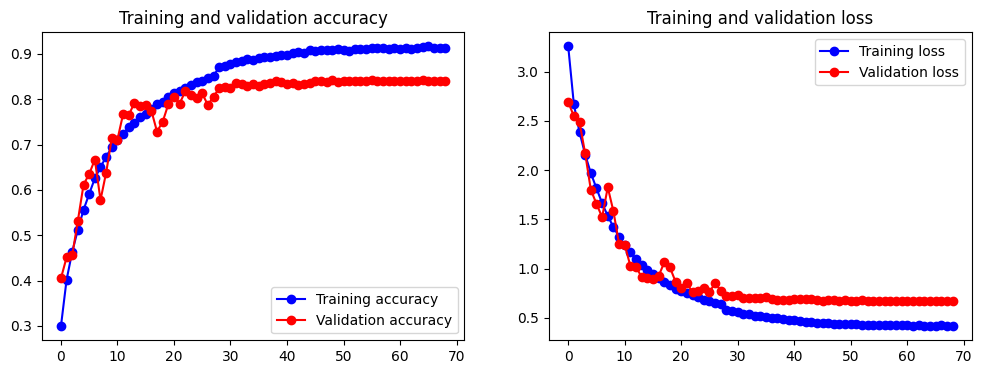

In [47]:
# Plotando os resultados
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_training_history(history)